## Analysis of Gresho Vortex using 2D Lax-Friederich

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import shutil

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py

sys.path.append('../main/') 
import plot_utils as pu
import utils as ut
from main import Fluid2D

In [5]:
N = 250  # Dimensions of the domain
lim = 0.5  # Domain limits

# Get the initial conditions for the Gresho vortex
Ics = ut.VortexIcs(N, lim)

CFL_factor = 1
T = 3  # Final time

# Data saved as data.hdf5 in
output_folder = f"../results/vortex/"

# Initialize the simulation class
Fluid = Fluid2D(Ics.x, Ics.y, Ics.D, Ics.U, Ics.V, Ics.P, CFL_factor=CFL_factor)
Fluid.set_output_folder(output_folder)

# Add tracers
fact = 0.9
M = 50
x_tracer = np.linspace(0, lim * fact, M)
y_tracer = np.linspace(0, -lim * fact, M)
Fluid.add_tracers(x_tracer, y_tracer)

# Run the simulation, and get 100 snapshots
Fluid.evaluate(T, snapshot_times=100)  # Around 10 seconds on my machine
ut.postprocess_data(Fluid.output_data_path)

Compute time: 1.23e+01 s


### 1. Initial conditions plot

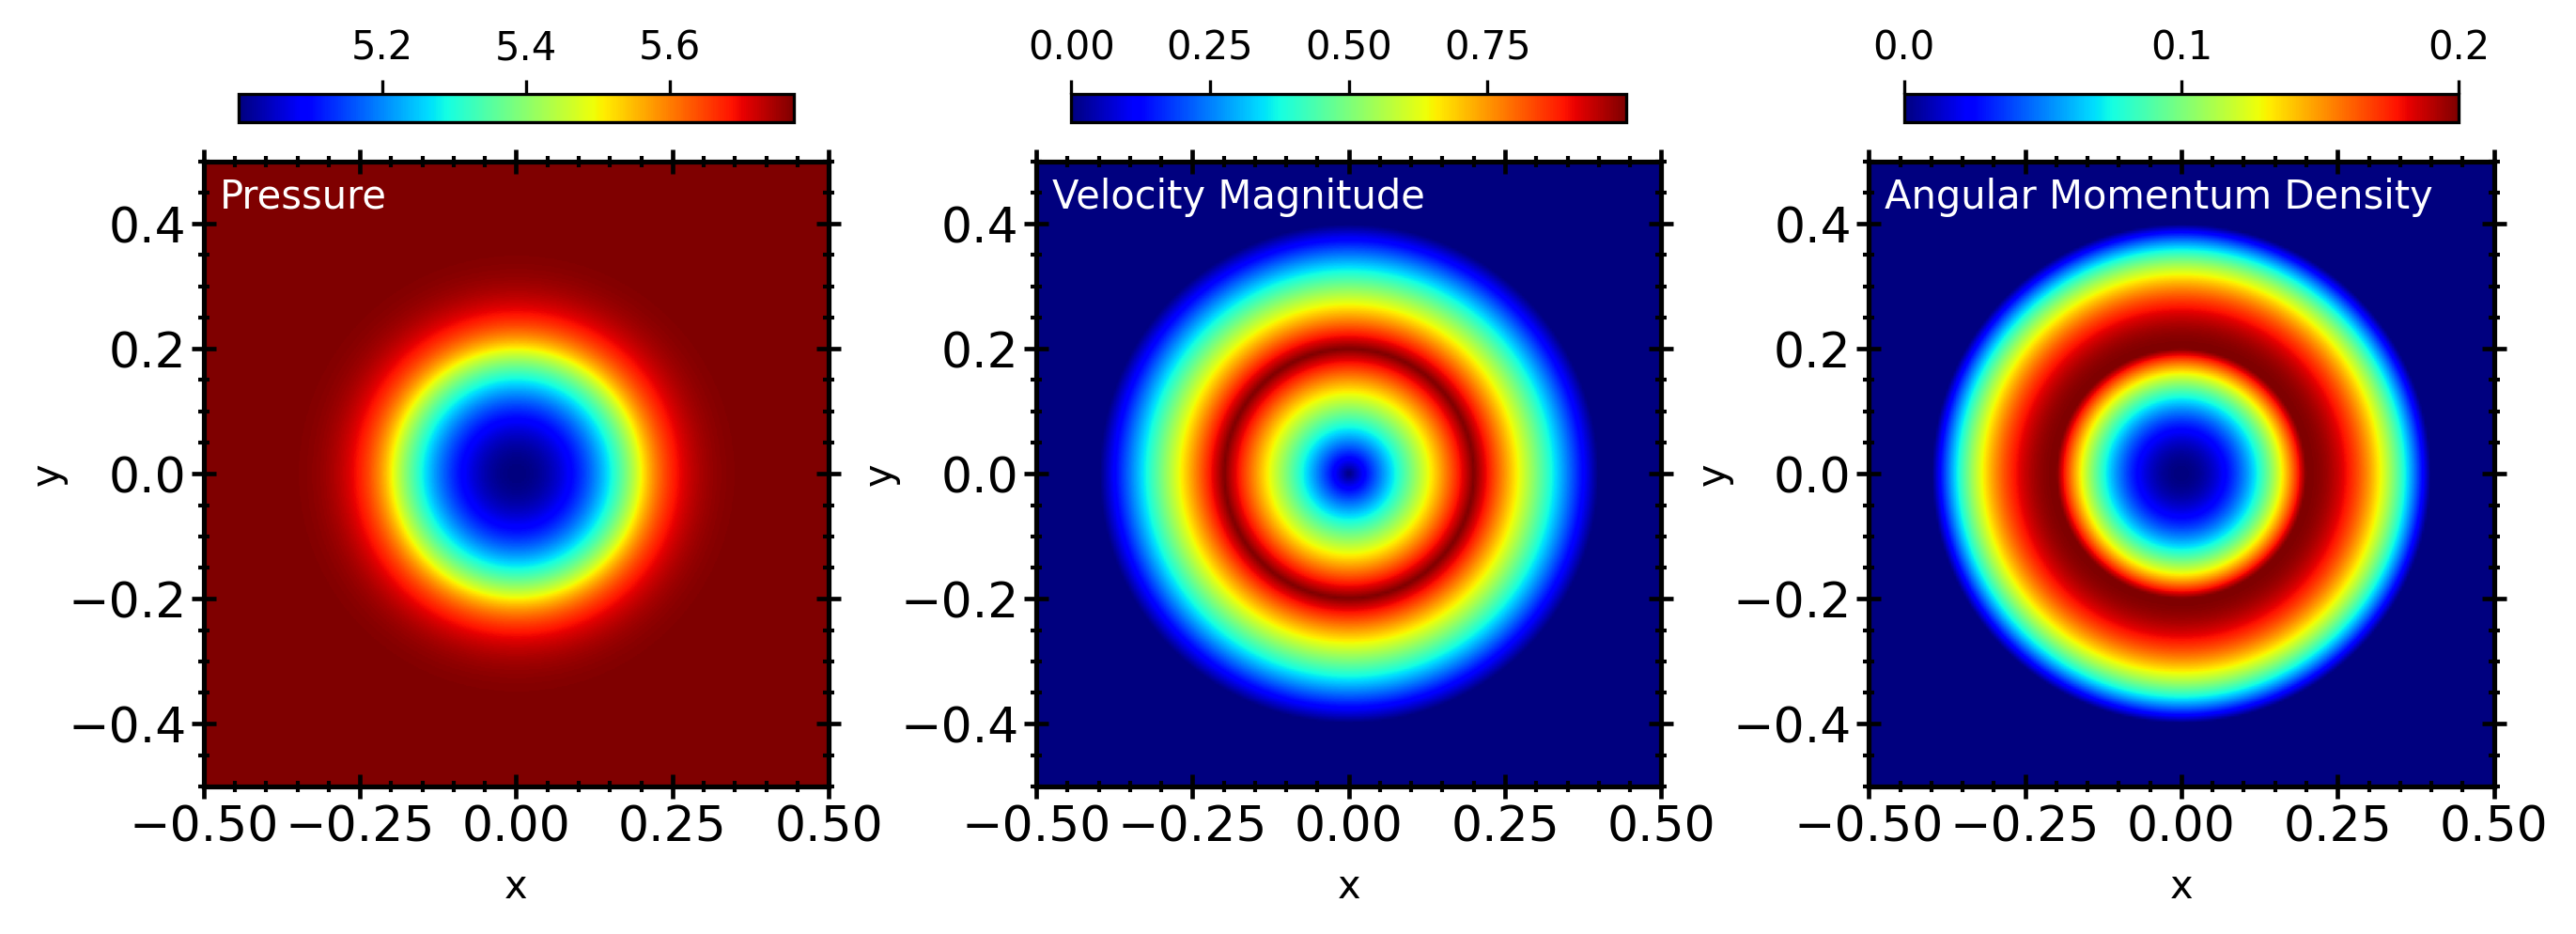

In [11]:
n_plots = 40

cmap = 'jet'
ts = 2
Fig = pu.Figure(1, 3, ratio=3, fig_size=1080)
Fig.grid = False
axs = Fig.get_axes(flat=True)
fig = Fig.fig

with h5py.File(Fluid.output_data_path, 'r') as file:

    M = file['Header'].attrs['N']
    x = file['Header'].attrs['X']
    y = file['Header'].attrs['Y']

    file_step = file[f"{0:03d}"]

    D = file_step['Density'][()]
    P = file_step['Pressure'][()]
    UU_VV = file_step['Velocity Magnitude'][()]
    L = file_step['Angular Momentum Density'][()]

    axs[0].imshow(P, extent=[x[0], x[-1], y[0], y[-1]], cmap=cmap)
    cbar = fig.colorbar(axs[0].get_images()[0], ax=axs[0], orientation='horizontal', location='top', shrink=0.8)
    axs[0].text(0.025, 0.975, 'Pressure', ha='left', va='top', transform=axs[0].transAxes, c='w')

    axs[1].imshow(UU_VV, extent=[x[0], x[-1], y[0], y[-1]], cmap=cmap)
    cbar = fig.colorbar(axs[1].get_images()[0], ax=axs[1], orientation='horizontal', location='top', shrink=0.8)
    axs[1].text(0.025, 0.975, 'Velocity Magnitude', ha='left', va='top', transform=axs[1].transAxes, c='w')


    axs[2].imshow(L, extent=[x[0], x[-1], y[0], y[-1]], cmap=cmap)
    cbar = fig.colorbar(axs[2].get_images()[0], ax=axs[2], orientation='horizontal', location='top', shrink=0.8)
    axs[2].text(0.025, 0.975, 'Angular Momentum Density', ha='left', va='top', transform=axs[2].transAxes, c='w')


    for ax in axs:
        ax.set_xlabel('x')
        ax.set_ylabel('y', labelpad=0)

Fig.save('../figures/P_V_L_initial.jpg', bbox_inches='tight')

### 2. Radial Velocity Profile

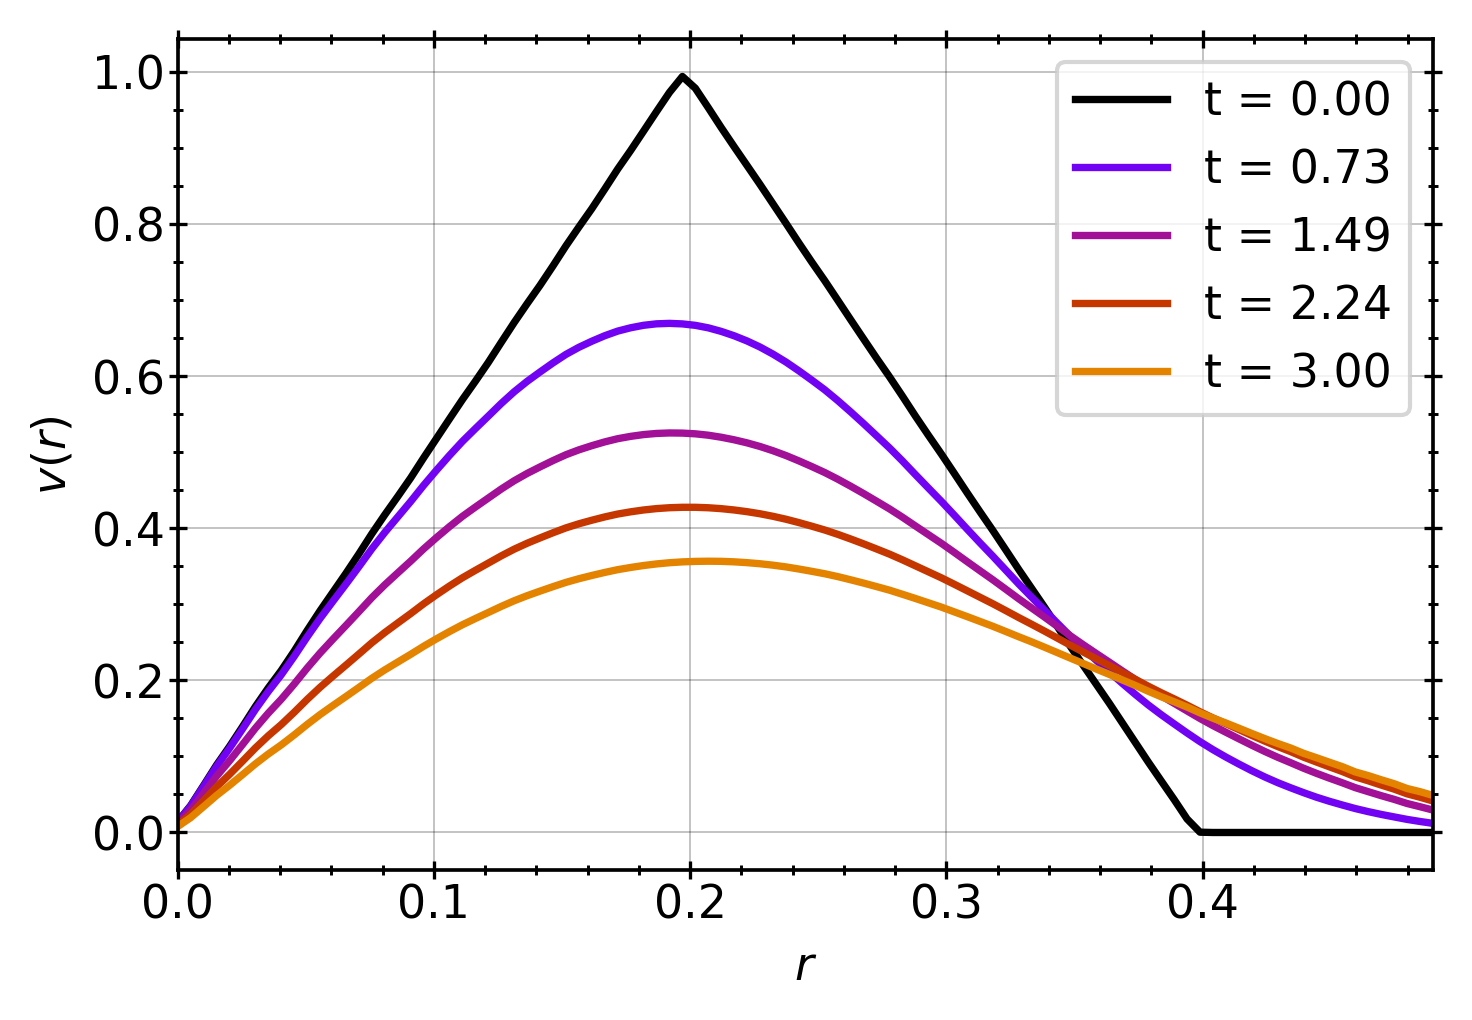

In [17]:
R_bins = np.linspace(0, lim, 100)
num_snapshots = 5
num_bins = len(R_bins) - 1

with h5py.File(Fluid.output_data_path, 'r') as file:
    M = file['Header'].attrs['N']
    x = file['Header'].attrs['X']
    y = file['Header'].attrs['Y']
    X, Y = np.meshgrid(x, y)
    Y = Y[::-1]
    R = np.sqrt(X**2 + Y**2)
    time = file.attrs['Time']

    idxs = np.linspace(0, M-1, num_snapshots, dtype=int)
    time = time[idxs]
    V_phi = np.zeros((len(idxs), num_bins))

    
    for i, idx in enumerate(idxs):
        file_step = file[f"{idx:03d}"]
        v_x = file_step["Velocity X"][()]
        v_y = file_step["Velocity Y"][()]
        v = np.sqrt(v_x**2 + v_y**2)

        for j in range(num_bins):
            idxs_ = np.where((R >= R_bins[j]) & (R < R_bins[j+1]))
            v_mean = np.mean(v[idxs_])
            V_phi[i, j] = v_mean

P = V_phi.shape[0]

# P colors from cmap jet
cmap = mpl.colormaps['gnuplot']
colors = cmap(np.linspace(0, 0.8, P))

lw = 0.4
ts = 2.5
Fig = pu.Figure(1, 1, fig_size=1080, ratio=1.5)
fig = Fig.fig
fs = Fig.fs
Fig.ts = ts
ax = Fig.get_axes()
for i in range(P):
    ax.plot(R_bins[:-1], V_phi[i,:], c=colors[i], lw=lw*fs, label=f"t = {time[i]:0.2f}")

ts_fact = 1
ax.set_xlabel(r'$r$', fontsize=fs*ts*ts_fact)
ax.set_ylabel(r'$v(r)$', fontsize=fs*ts*ts_fact)

ax.legend(fontsize=fs*ts)
ax.set_xlim([0, lim-0.01])


Fig.save('../figures/radial_profile_velocity.jpg', bbox_inches='tight')

### 2.5. Energy, Momentum and Angular Momentum 

In [9]:
N = 250  # Dimensions of the domain
lim = 0.5  # Domain limits

# Get the initial conditions for the Gresho vortex
Ics = ut.VortexIcs(N, lim)

CFL_factor = 1
T = 3  # Final time

# Data saved as data.hdf5 in
output_folder = f"../results/vortex/"

# Initialize the simulation class
Fluid = Fluid2D(Ics.x, Ics.y, Ics.D, Ics.U, Ics.V, Ics.P, CFL_factor=CFL_factor)
Fluid.set_output_folder(output_folder)

# Add tracers
fact = 0.9
M = 50
x_tracer = np.linspace(0, lim * fact, M)
y_tracer = np.linspace(0, -lim * fact, M)
Fluid.add_tracers(x_tracer, y_tracer)

# Run the simulation, and get 100 snapshots
Fluid.evaluate(T, snapshot_times=100)  # Around 10 seconds on my machine
ut.postprocess_data(Fluid.output_data_path)

Compute time: 8.54e+00 s


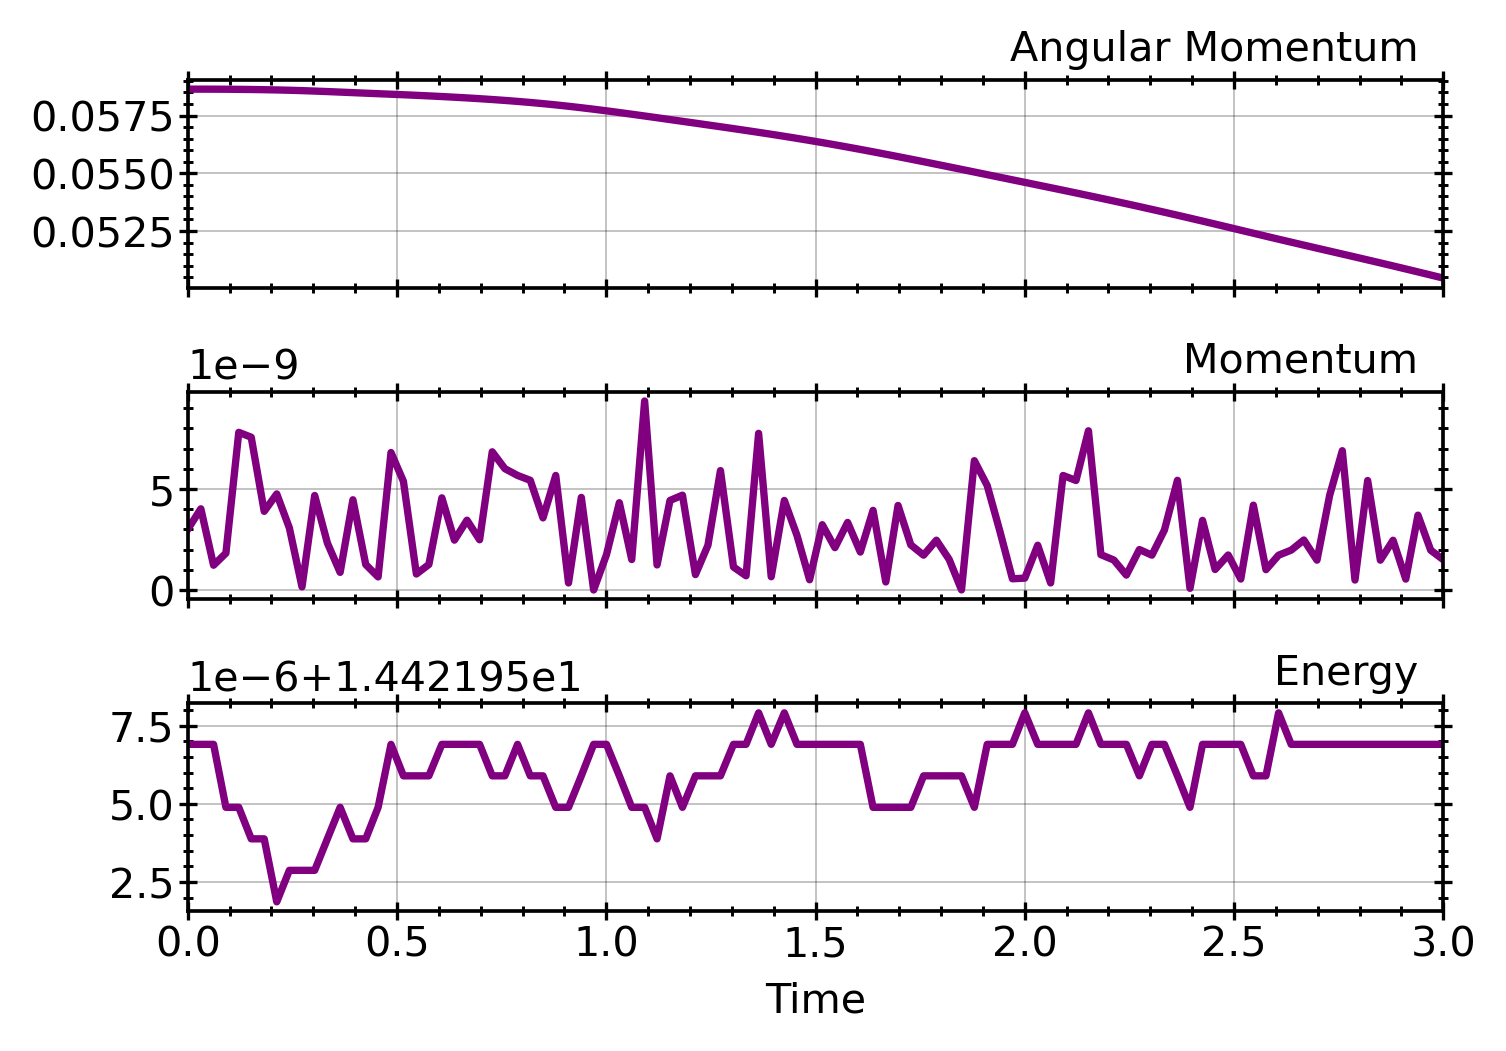

In [41]:
lw = 0.4
ts = 2.25
Fig = pu.Figure(3, 1, fig_size=1080, ratio=1.5, hspace=0.5)
fig = Fig.fig
fs = Fig.fs
Fig.ts = ts
axs = Fig.get_axes(flat=True)

with h5py.File(output_folder + 'data.hdf5', 'r') as file:

    time_data = file.attrs['Time'][()]
    L_data = file.attrs['Angular Momentum'][()] 
    P_data = file.attrs['Momentum'][()]
    E_data = file.attrs['Energy'][()]

    fields = [L_data, P_data, E_data]
    field_names = ['Angular Momentum', 'Momentum', 'Energy']
    for i, ax in enumerate(axs):
        ax.plot(time_data, fields[i], label=f'L', lw=lw*fs, c='purple')

        
        ax.yaxis.get_offset_text().set_fontsize(fs*ts)
        ax.set_xlim([0, T])
        ax.text(0.98, 1.05, field_names[i], ha='right', va='bottom', transform=ax.transAxes, c='k', fontsize=fs*ts)

        if i != 2:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Time', fontsize=fs*ts)

        # set log scale
        #ax.set_yscale('log')

Fig.save('../figures/conserved_quantities.jpg', bbox_inches='tight')

### 3. Angular Momentum Dilution

We run several simulations at increasing resolution and compare $L(t=0)$ and $L(t=3)$

This one may take a few minutes

In [7]:
N = 250
lim = 0.5

CFL_factor = 1
T = 3

N_list = np.arange(50, 500+50, 50, dtype=int)

In [ ]:

for i, N in enumerate(N_list):
    print(f'{N}x{N} grid. {i}/{len(N_list)-1}', end='\r')
    Ics = ut.VortexIcs(int(N), lim)
    output_folder = f'../results/vortex/vortex_{N}/'
    Fluid = Fluid2D(Ics.x, Ics.y, Ics.D, Ics.U, Ics.V, Ics.P, CFL_factor=CFL_factor)
    Fluid.set_output_folder(output_folder)
    Fluid.evaluate(T, snapshot_times=100, prints=False)
    ut.postprocess_data(Fluid.output_data_path)
print('\n')

In [ ]:
lw = 0.4
ts = 2.25
Fig = pu.Figure(1, 1, fig_size=1080, ratio=1)
fig = Fig.fig
fs = Fig.fs
Fig.ts = ts
ax = Fig.get_axes()

cmap = mpl.colormaps['gnuplot']
colors = cmap(np.linspace(0, 0.8, len(N_list)))

for i, N in enumerate(N_list):
    output_folder = f'../results/vortex/vortex_{N}/'
    with h5py.File(output_folder + 'data.hdf5', 'r') as file:
        time_data = file.attrs['Time'][()]
        L_data = file.attrs['Angular Momentum'][()] 

    ax.plot(time_data,L_data/L_data[0], label=f"N = {N}", lw=lw*fs, c=colors[i])

ax.set_xlim([0, 2.95])

ax.set_xlabel(r'$t$', fontsize=fs*ts)
ax.set_ylabel(r'$L \ / \ L_0$', fontsize=fs*ts)

ax.legend(fontsize=fs*ts*0.85, loc='lower left')

Fig.save('../figures/angular_momentum_evolution.jpg', bbox_inches='tight')

In [12]:
# delete theh data files
for N in N_list:
    output_folder = f'../results/vortex/vortex_{N}/'
    os.remove(output_folder + 'data.hdf5')
    os.rmdir(output_folder)

### 4. Angular Momentum Dilution as function of CFL and N

In [4]:
# Define the parameters of the simulations

lim = 0.5
T = 3

def make_even(integer):
    if integer % 2 == 0:
        return integer
    else:
        return integer + 1
    
K = 20
array = np.zeros((K, K))
N_list = np.linspace(50, 500, K, dtype=int)
N_list = [make_even(n) for n in N_list]
CFL_list = np.linspace(0.1, 2, K)
k = 0

In [ ]:
# Run the simulations (this one may take quite a while)

for i, N in enumerate(N_list):
    for j, CFL_factor in enumerate(CFL_list):
        
        k+=1
        Ics = ut.VortexIcs(int(N), lim)
        output_folder = f'../results/vortex/vortex_{N}_cdf_{CFL_factor:0.2f}/'
        Fluid = Fluid2D(Ics.x, Ics.y, Ics.D, Ics.U, Ics.V, Ics.P, CFL_factor=CFL_factor)
        Fluid.set_output_folder(output_folder)
        Fluid.evaluate(T, snapshot_times=20, prints=False)
        with h5py.File(Fluid.output_data_path, 'r') as file:
            if np.isnan(Fluid.dt):
                val = np.nan
            else:
                L0 = file['Header'].attrs['L_i'][()]
                Lf = file['Header'].attrs['L_f'][()]
                val = Lf / L0
    
        print(f'{N}x{N} | CFL = {CFL_factor:0.2f} {k}/{K*K-1}', end='\r')
        # os.remove(Fluid.output_data_path)  # delete the data file
        # os.rmdir(output_folder)  # delete the data file
        array[i,j] = val
print('\n')

In [5]:
# Read the data

array = np.zeros((K, K))

for i, N in enumerate(N_list):
    for j, CFL_factor in enumerate(CFL_list):
        data_path = f'../results/vortex/vortex_{N}_cdf_{CFL_factor:0.2f}/data.hdf5'
        with h5py.File(data_path, 'r') as file:

            #check if file['Header'].attrs['L_f'][()] exists
            if not 'L_f' in list(file['Header'].attrs.keys()):
                array[i, j] = np.nan

            else:
                L0 = file['Header'].attrs['L_i'][()]
                Lf = file['Header'].attrs['L_f'][()]
                array[i, j] = Lf / L0

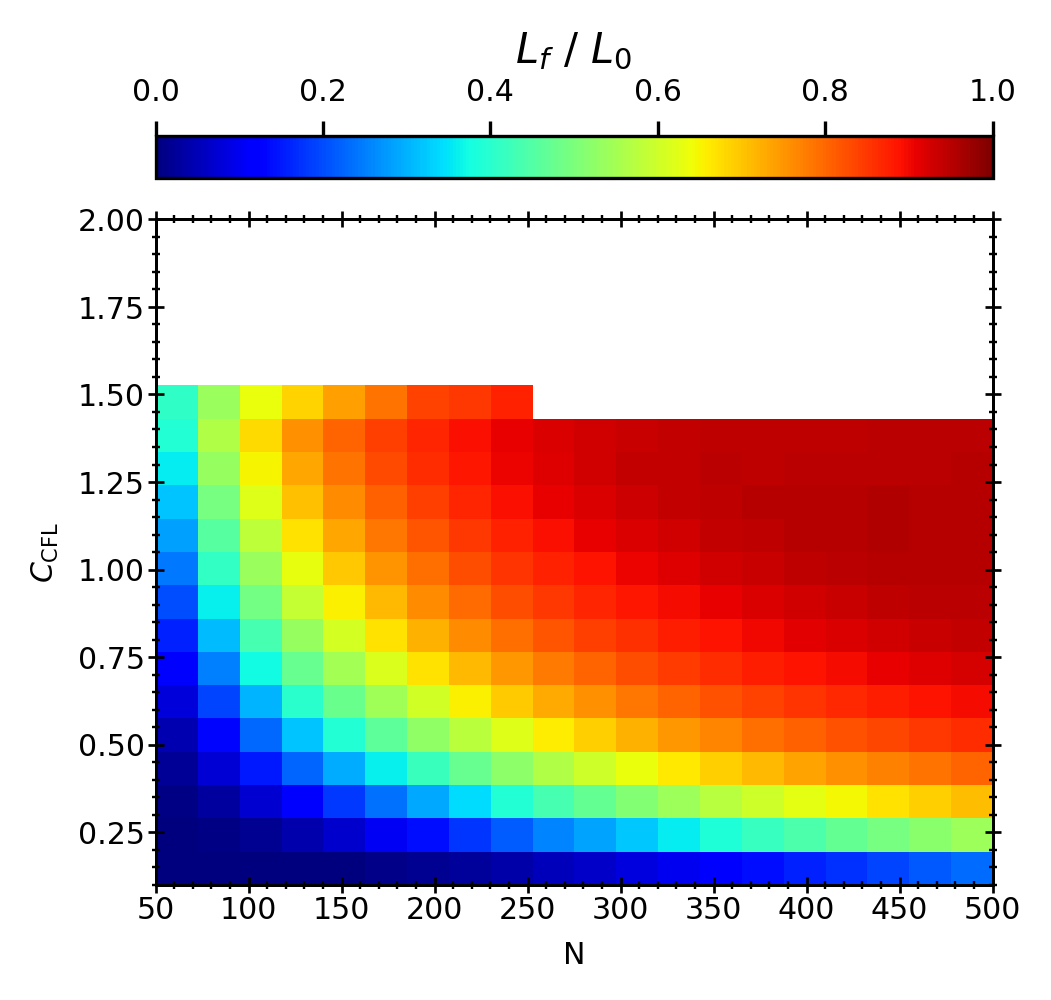

In [6]:
# Plot it

cmap = 'jet'
ts = 2
Fig = pu.Figure(1, 1, ratio=1, fig_size=1080)
Fig.grid = False
Fig.ts = ts
ax = Fig.get_axes()
fig = Fig.fig
fs = Fig.fs

extent = [N_list[0], N_list[-1], CFL_list[0], CFL_list[-1]]
ax.imshow(array.T[::-1,:], vmin=0, vmax=1, cmap=cmap, extent=extent)

# set aspect 1x1
ax.set_aspect('auto')

cbar = fig.colorbar(ax.get_images()[0], ax=ax, orientation='horizontal', location='top', shrink=1)
cbar.ax.set_xlabel('$L_f \ / \ L_0$', labelpad=1 * fs, color="k")
cbar.ax.tick_params(labelsize=fs*ts)

ax.set_xlabel('N', fontsize=fs*ts)
ax.set_ylabel(r'$C_{\text{CFL}}$', fontsize=fs*ts)

Fig.save('../figures/N_CFL_difusion.jpg', bbox_inches='tight')